Load the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
# path for desktop PC
sys.path.append(r'C:\Users\test\Masterarbeit')
# path for surface PC
#sys.path.append(r'C:\Users\Surface\Masterarbeit')

%matplotlib inline
# path for desktop PC
path = r"C:\Users\test\Masterarbeit\data\WZ_2_Feature_Engineered_Fynn6.xlsx"
# path for surface PC
#path = r"C:\Users\Surface\Masterarbeit\data\Produktionsdaten\WZ_2_Feature_Engineered_Fynn6.xlsx"

df = pd.read_excel(path)

Transformation Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import data_prep
import importlib
importlib.reload(data_prep)

# set the target variable
target = 'C1_V01_delta_kan'
#print(df.columns)
# get the numerical features
data_num = df.drop(['C1_V01_delta_kan'], axis = 1, inplace=False)
#print(data_num.columns)
# get the target values
data_labels = df[target].to_numpy()

# split the data into training, validation and test sets
# 60% training, 20%, validation, 20% test
X_temp, X_test_prep, y_temp, y_test = train_test_split(data_num, data_labels, test_size= 0.2, random_state=42)
X_train_prep, X_val_prep, y_train, y_val = train_test_split(X_temp, y_temp, test_size= 0.25, random_state=42)

# use coustom function "cat_transform" from prep.py to map the categorical features with their frequencies
X_train_prep, X_val_prep, X_test_prep = data_prep.cat_transform(X_train_prep, X_val_prep, X_test_prep, ['BT_NR', 'STP_NR'])
print(X_train_prep.columns)

# pipeline for preprocessing the data
# Standard Scaler for distribution with 0 mean and 1 std., normal distributed data
data_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
# get the feature names after preprocessing for the feature importance
feature_names = X_train_prep.columns

# fit the pipeline to the data and transform it
X_train = data_pipeline.fit_transform(X_train_prep)
X_val = data_pipeline.transform(X_val_prep)
X_test = data_pipeline.transform(X_test_prep)

# print the shapes of the data
print(data_num.shape, X_train.shape, X_val.shape, X_test.shape)

Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')
(52011, 37) (31206, 37) (10402, 37) (10403, 37)


RQF Implementation with quantile-forest according to Mainhausen (2006) paper https://zillow.github.io/quantile-forest/gallery/plot_qrf_prediction_intervals.html

https://github.com/zillow/quantile-forest?tab=readme-ov-file

In [11]:
from quantile_forest import RandomForestQuantileRegressor
#define model, 200 different trees, max_depth of 8 delivers the best coverage and R² Score
qrf = RandomForestQuantileRegressor(n_estimators=500, max_depth=10, n_jobs=-1, random_state=42)

#train model
qrf.fit(X_train, y_train)

RandomForestQuantileRegressor(max_depth=10, n_estimators=500, n_jobs=-1,
                              random_state=42)

Optuna Hyperparameter Search

In [8]:
import optuna
from optuna.trial import TrialState
from sklearn.metrics import mean_pinball_loss
from quantile_forest import RandomForestQuantileRegressor

def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=50)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 4, 10)

    # Create the model with the suggested hyperparameters
    model = RandomForestQuantileRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1,
        random_state=42
    )

    # Fit the model
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val, quantiles=[0.025, 0.5, 0.975])
    # pinball loss calculation

    pinball_2_5 = mean_pinball_loss(y_val, y_val_pred[:, 0], alpha=0.025)
    pinball_50 = mean_pinball_loss(y_val, y_val_pred[:, 1], alpha=0.5)
    pinball_97_5 = mean_pinball_loss(y_val, y_val_pred[:, 2], alpha=0.975)

    return (pinball_2_5 + pinball_50 + pinball_97_5) / 3

In [9]:
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler()
    )

study.optimize(objective, n_trials=50, timeout=None, n_jobs=1, show_progress_bar=True)

print(study.best_params)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-07-12 11:58:19,943] A new study created in memory with name: no-name-7a71ca7a-811c-4f1d-970e-7dce150e051f
Best trial: 0. Best value: 0.47945:   2%|▏         | 1/50 [00:06<05:37,  6.89s/it]

[I 2025-07-12 11:58:26,835] Trial 0 finished with value: 0.4794496967560326 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.4794496967560326.


Best trial: 1. Best value: 0.476461:   4%|▍         | 2/50 [00:15<06:28,  8.09s/it]

[I 2025-07-12 11:58:35,765] Trial 1 finished with value: 0.4764614006565244 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.4764614006565244.


Best trial: 2. Best value: 0.444798:   6%|▌         | 3/50 [00:34<10:14, 13.08s/it]

[I 2025-07-12 11:58:54,783] Trial 2 finished with value: 0.4447983499630279 and parameters: {'n_estimators': 400, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.4447983499630279.


Best trial: 2. Best value: 0.444798:   8%|▊         | 4/50 [00:47<09:53, 12.91s/it]

[I 2025-07-12 11:59:07,423] Trial 3 finished with value: 0.6490812520013379 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.4447983499630279.


Best trial: 2. Best value: 0.444798:  10%|█         | 5/50 [01:23<15:54, 21.21s/it]

[I 2025-07-12 11:59:43,331] Trial 4 finished with value: 0.5080303530555023 and parameters: {'n_estimators': 850, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.4447983499630279.


Best trial: 2. Best value: 0.444798:  12%|█▏        | 6/50 [01:51<17:09, 23.41s/it]

[I 2025-07-12 12:00:11,030] Trial 5 finished with value: 0.4580289946234299 and parameters: {'n_estimators': 600, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.4447983499630279.


Best trial: 2. Best value: 0.444798:  14%|█▍        | 7/50 [01:57<12:46, 17.81s/it]

[I 2025-07-12 12:00:17,313] Trial 6 finished with value: 0.5096189583701854 and parameters: {'n_estimators': 150, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.4447983499630279.


Best trial: 2. Best value: 0.444798:  16%|█▌        | 8/50 [02:41<18:23, 26.28s/it]

[I 2025-07-12 12:01:01,729] Trial 7 finished with value: 0.4554411923328046 and parameters: {'n_estimators': 950, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.4447983499630279.


Best trial: 2. Best value: 0.444798:  18%|█▊        | 9/50 [02:46<13:22, 19.57s/it]

[I 2025-07-12 12:01:06,529] Trial 8 finished with value: 0.44840931805482126 and parameters: {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.4447983499630279.


Best trial: 9. Best value: 0.420252:  20%|██        | 10/50 [03:10<13:56, 20.91s/it]

[I 2025-07-12 12:01:30,462] Trial 9 finished with value: 0.42025193441305353 and parameters: {'n_estimators': 450, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 9 with value: 0.42025193441305353.


Best trial: 9. Best value: 0.420252:  22%|██▏       | 11/50 [03:46<16:33, 25.48s/it]

[I 2025-07-12 12:02:06,286] Trial 10 finished with value: 0.42836227499218915 and parameters: {'n_estimators': 700, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 9 with value: 0.42025193441305353.


Best trial: 9. Best value: 0.420252:  24%|██▍       | 12/50 [04:19<17:37, 27.83s/it]

[I 2025-07-12 12:02:39,495] Trial 11 finished with value: 0.42842087825898867 and parameters: {'n_estimators': 650, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 9 with value: 0.42025193441305353.


Best trial: 12. Best value: 0.419891:  26%|██▌       | 13/50 [04:59<19:29, 31.61s/it]

[I 2025-07-12 12:03:19,813] Trial 12 finished with value: 0.41989134650127385 and parameters: {'n_estimators': 750, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 12 with value: 0.41989134650127385.


Best trial: 12. Best value: 0.419891:  28%|██▊       | 14/50 [05:23<17:27, 29.11s/it]

[I 2025-07-12 12:03:43,127] Trial 13 finished with value: 0.4246882193101888 and parameters: {'n_estimators': 450, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 12 with value: 0.41989134650127385.


Best trial: 12. Best value: 0.419891:  30%|███       | 15/50 [06:03<19:00, 32.58s/it]

[I 2025-07-12 12:04:23,774] Trial 14 finished with value: 0.43131323883688233 and parameters: {'n_estimators': 800, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 12 with value: 0.41989134650127385.


Best trial: 12. Best value: 0.419891:  32%|███▏      | 16/50 [06:21<15:55, 28.09s/it]

[I 2025-07-12 12:04:41,441] Trial 15 finished with value: 0.6443551701047076 and parameters: {'n_estimators': 500, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 12 with value: 0.41989134650127385.


Best trial: 12. Best value: 0.419891:  34%|███▍      | 17/50 [06:37<13:23, 24.35s/it]

[I 2025-07-12 12:04:57,090] Trial 16 finished with value: 0.4227266679404602 and parameters: {'n_estimators': 300, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 12 with value: 0.41989134650127385.


Best trial: 12. Best value: 0.419891:  36%|███▌      | 18/50 [07:19<15:50, 29.71s/it]

[I 2025-07-12 12:05:39,273] Trial 17 finished with value: 0.4224462731798373 and parameters: {'n_estimators': 800, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 12 with value: 0.41989134650127385.


Best trial: 12. Best value: 0.419891:  38%|███▊      | 19/50 [08:10<18:41, 36.18s/it]

[I 2025-07-12 12:06:30,522] Trial 18 finished with value: 0.4312893140676073 and parameters: {'n_estimators': 1000, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 12 with value: 0.41989134650127385.


Best trial: 12. Best value: 0.419891:  40%|████      | 20/50 [08:32<15:58, 31.94s/it]

[I 2025-07-12 12:06:52,571] Trial 19 finished with value: 0.5443697038027544 and parameters: {'n_estimators': 550, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 12 with value: 0.41989134650127385.


Best trial: 12. Best value: 0.419891:  42%|████▏     | 21/50 [09:08<16:02, 33.19s/it]

[I 2025-07-12 12:07:28,704] Trial 20 finished with value: 0.42766032097533335 and parameters: {'n_estimators': 700, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 12 with value: 0.41989134650127385.


Best trial: 12. Best value: 0.419891:  44%|████▍     | 22/50 [09:50<16:40, 35.72s/it]

[I 2025-07-12 12:08:10,319] Trial 21 finished with value: 0.4224462731798373 and parameters: {'n_estimators': 800, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 12 with value: 0.41989134650127385.


Best trial: 12. Best value: 0.419891:  46%|████▌     | 23/50 [10:35<17:17, 38.42s/it]

[I 2025-07-12 12:08:55,021] Trial 22 finished with value: 0.43098043345089887 and parameters: {'n_estimators': 900, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 12 with value: 0.41989134650127385.


Best trial: 23. Best value: 0.418382:  48%|████▊     | 24/50 [11:15<16:52, 38.95s/it]

[I 2025-07-12 12:09:35,236] Trial 23 finished with value: 0.4183818170185622 and parameters: {'n_estimators': 750, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 23 with value: 0.4183818170185622.


Best trial: 23. Best value: 0.418382:  50%|█████     | 25/50 [11:52<15:59, 38.36s/it]

[I 2025-07-12 12:10:12,221] Trial 24 finished with value: 0.4229084993719157 and parameters: {'n_estimators': 700, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 23 with value: 0.4183818170185622.


Best trial: 25. Best value: 0.415514:  52%|█████▏    | 26/50 [12:22<14:22, 35.94s/it]

[I 2025-07-12 12:10:42,501] Trial 25 finished with value: 0.41551446195643477 and parameters: {'n_estimators': 550, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.41551446195643477.


Best trial: 25. Best value: 0.415514:  54%|█████▍    | 27/50 [12:42<11:57, 31.21s/it]

[I 2025-07-12 12:11:02,662] Trial 26 finished with value: 0.7224646863868326 and parameters: {'n_estimators': 600, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.41551446195643477.


Best trial: 25. Best value: 0.415514:  56%|█████▌    | 28/50 [13:19<12:02, 32.85s/it]

[I 2025-07-12 12:11:39,348] Trial 27 finished with value: 0.4402623498521119 and parameters: {'n_estimators': 750, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.41551446195643477.


Best trial: 25. Best value: 0.415514:  58%|█████▊    | 29/50 [13:48<11:03, 31.60s/it]

[I 2025-07-12 12:12:08,035] Trial 28 finished with value: 0.4306102988829472 and parameters: {'n_estimators': 550, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 25 with value: 0.41551446195643477.


Best trial: 25. Best value: 0.415514:  60%|██████    | 30/50 [14:35<12:04, 36.22s/it]

[I 2025-07-12 12:12:55,034] Trial 29 finished with value: 0.4229487358150276 and parameters: {'n_estimators': 900, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 25 with value: 0.41551446195643477.


Best trial: 30. Best value: 0.41537:  62%|██████▏   | 31/50 [15:10<11:22, 35.91s/it] 

[I 2025-07-12 12:13:30,210] Trial 30 finished with value: 0.41536997995016994 and parameters: {'n_estimators': 650, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  64%|██████▍   | 32/50 [15:44<10:39, 35.53s/it]

[I 2025-07-12 12:14:04,871] Trial 31 finished with value: 0.41536997995016994 and parameters: {'n_estimators': 650, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  66%|██████▌   | 33/50 [16:16<09:41, 34.23s/it]

[I 2025-07-12 12:14:36,043] Trial 32 finished with value: 0.42078066485852084 and parameters: {'n_estimators': 600, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  68%|██████▊   | 34/50 [16:51<09:11, 34.46s/it]

[I 2025-07-12 12:15:11,044] Trial 33 finished with value: 0.41536997995016994 and parameters: {'n_estimators': 650, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  70%|███████   | 35/50 [17:23<08:28, 33.88s/it]

[I 2025-07-12 12:15:43,577] Trial 34 finished with value: 0.4286660626051481 and parameters: {'n_estimators': 650, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  72%|███████▏  | 36/50 [17:49<07:20, 31.44s/it]

[I 2025-07-12 12:16:09,340] Trial 35 finished with value: 0.4210595405200523 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  74%|███████▍  | 37/50 [18:06<05:52, 27.14s/it]

[I 2025-07-12 12:16:26,420] Trial 36 finished with value: 0.4402367738692079 and parameters: {'n_estimators': 350, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  76%|███████▌  | 38/50 [18:36<05:36, 28.04s/it]

[I 2025-07-12 12:16:56,584] Trial 37 finished with value: 0.4558063913917596 and parameters: {'n_estimators': 650, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  78%|███████▊  | 39/50 [19:02<05:02, 27.47s/it]

[I 2025-07-12 12:17:22,717] Trial 38 finished with value: 0.418049755739281 and parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  80%|████████  | 40/50 [19:13<03:45, 22.51s/it]

[I 2025-07-12 12:17:33,653] Trial 39 finished with value: 0.47714766379294055 and parameters: {'n_estimators': 250, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  82%|████████▏ | 41/50 [19:37<03:25, 22.87s/it]

[I 2025-07-12 12:17:57,377] Trial 40 finished with value: 0.5440474647812119 and parameters: {'n_estimators': 600, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  84%|████████▍ | 42/50 [20:04<03:11, 23.99s/it]

[I 2025-07-12 12:18:23,965] Trial 41 finished with value: 0.4155248717598379 and parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  86%|████████▌ | 43/50 [20:25<02:41, 23.14s/it]

[I 2025-07-12 12:18:45,125] Trial 42 finished with value: 0.415663322772664 and parameters: {'n_estimators': 400, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  88%|████████▊ | 44/50 [20:47<02:16, 22.79s/it]

[I 2025-07-12 12:19:07,115] Trial 43 finished with value: 0.4303386753412806 and parameters: {'n_estimators': 450, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  90%|█████████ | 45/50 [21:17<02:04, 25.00s/it]

[I 2025-07-12 12:19:37,259] Trial 44 finished with value: 0.41551446195643477 and parameters: {'n_estimators': 550, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  92%|█████████▏| 46/50 [21:50<01:50, 27.52s/it]

[I 2025-07-12 12:20:10,661] Trial 45 finished with value: 0.42322129706106204 and parameters: {'n_estimators': 650, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  94%|█████████▍| 47/50 [22:19<01:24, 28.04s/it]

[I 2025-07-12 12:20:39,900] Trial 46 finished with value: 0.41551446195643477 and parameters: {'n_estimators': 550, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  96%|█████████▌| 48/50 [22:52<00:58, 29.27s/it]

[I 2025-07-12 12:21:12,053] Trial 47 finished with value: 0.429985513485788 and parameters: {'n_estimators': 650, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537:  98%|█████████▊| 49/50 [23:28<00:31, 31.53s/it]

[I 2025-07-12 12:21:48,866] Trial 48 finished with value: 0.4184153603367542 and parameters: {'n_estimators': 700, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 30 with value: 0.41536997995016994.


Best trial: 30. Best value: 0.41537: 100%|██████████| 50/50 [23:49<00:00, 28.59s/it]

[I 2025-07-12 12:22:09,675] Trial 49 finished with value: 0.42124666202412997 and parameters: {'n_estimators': 400, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 30 with value: 0.41536997995016994.
{'n_estimators': 650, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 4}
Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  0
  Number of complete trials:  50
Best trial:
  Value:  0.41536997995016994
  Params: 
    n_estimators: 650
    max_depth: 15
    min_samples_split: 6
    min_samples_leaf: 4


Train best QRF

In [10]:
best_params = study.best_params
print("Best hyperparameters:", best_params)

qrf = RandomForestQuantileRegressor(    
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    n_jobs=-1,
    random_state=42
)

qrf.fit(X_train, y_train)

Best hyperparameters: {'n_estimators': 650, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 4}


,n_estimators,650
,default_quantiles,0.5
,criterion,'squared_error'
,max_depth,15
,min_samples_split,6
,min_samples_leaf,4
,max_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


Mean Squared Error on Train Data: 4.245
R² on Train Data: 0.928
Mean Squared Error on Test Data: 7.514
R² on Test Data: 0.868
Coverage: 97.00%


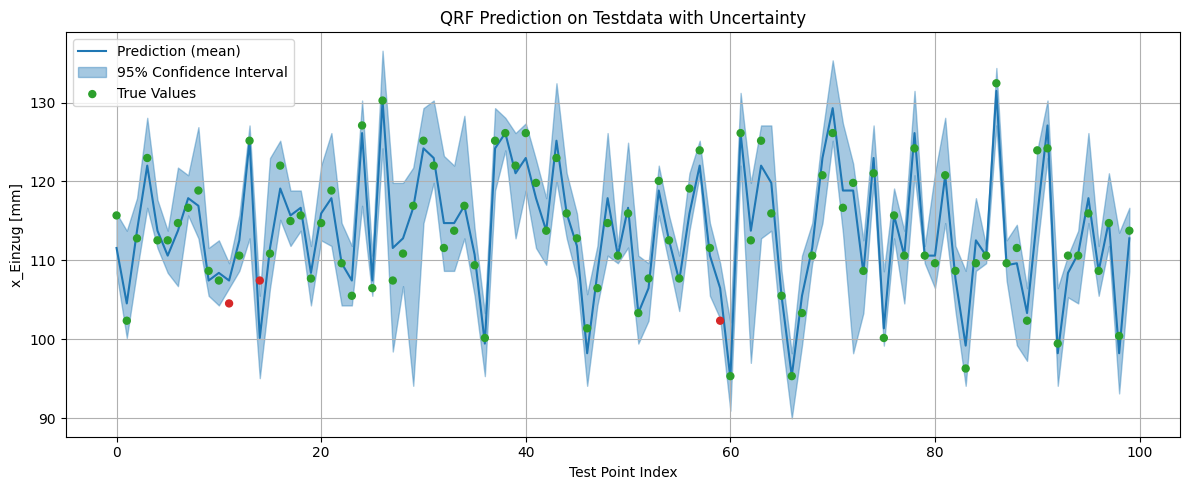

In [11]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#! handling the train data
#make predicitons on train dataset
y_train_pred_rqf = qrf.predict(X_train, quantiles=[0.025, 0.5, 0.975])
#calculate MSE and R2 Score for train data
mse_train_rqf = mean_squared_error(y_train, y_train_pred_rqf[:, 1])
r2_train_rqf = r2_score(y_train, y_train_pred_rqf[:, 1])
print(f"Mean Squared Error on Train Data: {mse_train_rqf:.3f}")
print(f"R² on Train Data: {r2_train_rqf:.3f}")

#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_test), num_points, replace=False)
random_indices.sort()

# Make predictions on test dataset
y_test_pred_rqf = qrf.predict(X_test, quantiles=[0.025, 0.5, 0.975])
# Calculate MSE and R² Score for test data
mse_test_rqf = mean_squared_error(y_test, y_test_pred_rqf[:, 1])
r2_test_rqf = r2_score(y_test, y_test_pred_rqf[:, 1])

print(f"Mean Squared Error on Test Data: {mse_test_rqf:.3f}")
print(f"R² on Test Data: {r2_test_rqf:.3f}")

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test[random_indices] >= y_test_pred_rqf[random_indices, 0]) & (y_test[random_indices] <= y_test_pred_rqf[random_indices, 2])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval]

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Plotting the prediction with uncertainty and true values
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)

# Plot predicted mean
plt.plot(x_axis, y_test_pred_rqf[random_indices, 1], label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, y_test_pred_rqf[random_indices, 0], y_test_pred_rqf[random_indices, 2],
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, y_test[random_indices], label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("QRF Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Model Testing Random Forest


In [13]:
from sklearn.ensemble import RandomForestRegressor

#define model, 50 different trees
rnd_reg = RandomForestRegressor(n_estimators=500, max_depth=  10, n_jobs=-1)
#train model
rnd_reg.fit(X_train, y_train)

#prepare a data frame for the important features
importances = rnd_reg.feature_importances_
features = feature_names

# Create a DataFrame to display feature importance, sorted descending
feat_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

#show important features
display(feat_df)

#make some predicitons on train and test dataset
y_train_pred = rnd_reg.predict(X_train)
y_test_pred = rnd_reg.predict(X_test)

#calculate R2 Score for train and test data
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R2 Score Train: {r2_train:.3f}, Test: {r2_test:.3f}")


,Feature,Importance
26,week_sin,0.289754
27,week_cos,0.119010
1,K1,0.095483
38,STP_NR_freq,0.072542
10,PP_10,0.063682
5,K8,0.046343
22,day_sin,0.043869
13,RF_10,0.029877
14,TD_10,0.025528
23,day_cos,0.025489


R2 Score Train: 0.873, Test: 0.842
